In [1]:
is_skip = True

# Data params
batch_size = 256
# batch_size = 16
pred_len = 30

# Model params
d_model = 128
nhead = 2
d_ff = 256
dropout = 0.1
num_layers = 1

# Import

In [2]:
import os
import joblib
import copy
import time

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

from PIL import Image
from torchvision import transforms
import cv2
from transformers import ViTImageProcessor, MobileViTModel, MobileViTConfig, ViTModel, AutoImageProcessor, ViTConfig, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer
from skimage import io

# device = torch.device("cuda:0")
device = torch.device("cpu")
tqdm.pandas()

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    us_holiday = holidays.US()
    
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})

In [4]:
def preprocess(data):
    data = data.copy()

    # Image path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/resized_images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

    # Make sales
    data = data.groupby(["t_dat", "article_id", "img_path"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=10)]

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["img_path"] = data["img_path"].fillna(method="ffill")
    data = data.sort_values(["article_id", "t_dat"])
    
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=pred_len*2)]
    data["time_idx"] = data.groupby("article_id").cumcount()
    data["time_idx"] = data["size"] - data["time_idx"]

    # Make holidays
    holiday = holidays.US()
    data["holiday"] = data["t_dat"].apply(lambda x: 1 if x in holiday else 0)

    # Temporal information
    # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year / (data["t_dat"].dt.year.max() + 1)

    # Append meta data
    data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "product_type_name"]], on="article_id")

    # Split
    df_train = data[data["time_idx"] > 30].copy()
    df_train["time_idx"] = df_train["time_idx"] - 30
    df_valid = data.copy()

    # Output
    return df_train.reset_index(drop=True), df_valid.reset_index(drop=True)

if not is_skip:
    df_prep = df_trans.copy()#.iloc[:1000]
    df_train, df_valid = preprocess(df_prep)
    
    df_train.to_parquet("df_train.pq")
    df_valid.to_parquet("df_valid.pq")

### Dataset

In [5]:
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)
    
    def inverse_transform(self, x, y=None):
        return np.expm1(x)
    
class NoneScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return x

In [6]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")
mask_value = 999

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, is_train=True):
        self.is_train = is_train
        self.data_li = []
        self.min_val, self.max_val = data["sales"].min(), data["sales"].max()
        data.groupby("article_id").progress_apply(lambda x: self.data_li.append(x))

    def __len__(self):
        return len(self.data_li)
    
    def __getitem__(self, idx):
        data = self.data_li[idx]

        # Get and scale data
        sales_scaler, price_scaler = LogScaler(), NoneScaler()
        sales = sales_scaler.fit_transform(data["sales"].values.reshape(-1,1)).reshape(-1)
        price = price_scaler.fit_transform(data["price"].values.reshape(-1,1)).reshape(-1)
        dow = data["dow"].values
        y = sales_scaler.transform(data["sales"].values.reshape(-1,1)).reshape(-1)

        # Generate mask: 1 if masked, 0 else
        if self.is_train:
            sales, mask = self.generate_mask(sales, sales_scaler)
        else:
            sales, mask, start_idx, end_idx = self.generate_valid_mask(sales, sales_scaler)
            price = price[start_idx:end_idx]
            dow = dow[start_idx:end_idx]
            y = y[start_idx:end_idx]
        return {"sales": torch.Tensor(sales), "price":torch.Tensor(price), "dow":torch.IntTensor(dow), "mask":torch.Tensor(mask), "y":torch.Tensor(y), "length": len(y)}
        
    def generate_mask(self, data, scaler):
        index = np.arange(len(data))
        num_blocks = 10
        block_size = len(data)//num_blocks
        block_idx = np.random.choice(range(1, num_blocks), num_blocks//3, replace=False) # Mask for 33%
        mask = np.zeros(len(data))
        for idx in block_idx:
            data[idx*block_size : idx*block_size+block_size] = 0
            mask[idx*block_size : idx*block_size+block_size] = 1
        return data, mask

    def generate_valid_mask(self, data, scaler):

        start_idx = 0
        end_idx = 90

        # while True:
        #     start_idx = np.random.randint(0, len(data)-pred_len)
        #     end_idx = np.random.randint(start_idx, len(data))
        #     if end_idx - start_idx >= 30:
        #         break



        data = data[start_idx:end_idx]
        # data[-30:] = scaler.transform([[mask_value]]).reshape(-1)
        data[-30:] = 0
        
        mask = np.zeros(len(data))
        mask[-30:] = 1

        return data, mask, start_idx, end_idx
            
def collate_fn(batch_li):
    sales = [batch["sales"] for batch in batch_li]
    price = [batch["price"] for batch in batch_li]
    dow = [batch["dow"] for batch in batch_li]
    mask = [batch["mask"] for batch in batch_li]
    y = [batch["y"] for batch in batch_li]
    length = [batch["length"] for batch in batch_li]

    sales = torch.nn.utils.rnn.pad_sequence(sales, batch_first=True)
    price = torch.nn.utils.rnn.pad_sequence(price, batch_first=True)
    dow = torch.nn.utils.rnn.pad_sequence(dow, batch_first=True)
    mask = torch.nn.utils.rnn.pad_sequence(mask, padding_value=2, batch_first=True)
    y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True)
    
    return {"sales": sales, "price":price, "dow":dow, "mask":mask, "y":y, "length": torch.IntTensor(length)}

train_dataset = Dataset(df_train)
valid_dataset = Dataset(df_valid, is_train=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)

for data in train_dataloader:
    print("sales:", data["sales"].shape)
    print("price:", data["price"].shape)
    print("dow:", data["dow"].shape)
    print("mask:", data["mask"].shape)
    print("y:", data["y"].shape)
    print("length:", data["length"].shape)
    break

100%|██████████| 75048/75048 [00:02<00:00, 27994.91it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales: torch.Size([256, 702])
price: torch.Size([256, 702])
dow: torch.Size([256, 702])
mask: torch.Size([256, 702])
y: torch.Size([256, 702])
length: torch.Size([256])


In [7]:
for data in valid_dataloader:
    print("sales:", data["sales"].shape)
    print("price:", data["price"].shape)
    print("mask:", data["mask"].shape)
    print("y:", data["y"].shape)
    print("length:", data["length"].shape)
    break

sales: torch.Size([256, 90])
price: torch.Size([256, 90])
mask: torch.Size([256, 90])
y: torch.Size([256, 90])
length: torch.Size([256])


# Architecture

### Helper

In [8]:
from torch.nn import functional as F

def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

def _generate_square_subsequent_mask(sz, device, dtype):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None,size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class PositionalEncoding(torch.nn.Module):
    # PE(pos, 2i) = sin(pos/10000^{2i/d_model}), 
    # PE(pos, 2i+1) = cos(pos/10000^{2i/d_model})
    def __init__(self, max_len, d_model, dropout):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)

        position = torch.arange(max_len).reshape(-1,1).to(device)
        i = torch.arange(d_model).to(device)//2
        exp_term = 2*i/d_model
        div_term = torch.pow(10000, exp_term).reshape(1, -1)
        self.pos_encoded = position / div_term

        self.pos_encoded[:, 0::2] = torch.sin(self.pos_encoded[:, 0::2])
        self.pos_encoded[:, 1::2] = torch.cos(self.pos_encoded[:, 1::2])

    def forward(self, x):
        output = x + self.pos_encoded[:x.shape[1], :]
        return self.dropout(output)

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout()

        if activation == "relu":
            self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout(x)

class DecoderLayer(torch.nn.TransformerDecoderLayer):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=False, memory_is_causal=False):
        x = tgt
        if self.norm_first: raise
        else:
            self_attn_output, self_attn_weight = self._sa_block(x, tgt_mask, tgt_key_padding_mask, tgt_is_causal)
            x = self.norm1(x + self_attn_output)

            cross_attn_output, cross_attn_weight = self._mha_block(x, memory, memory_mask, memory_key_padding_mask, memory_is_causal)
            x = self.norm2(x + cross_attn_output)
            x = self.norm3(x + self._ff_block(x))
        return x, self_attn_weight, cross_attn_weight

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, self_attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           is_causal=is_causal,
                           need_weights=True, average_attn_weights=False)
        return self.dropout1(x), self_attn_weight

    # multihead attention block
    def _mha_block(self, x, mem, attn_mask, key_padding_mask, is_causal=False):
        x, cross_attn_weight = self.multihead_attn(x, mem, mem,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                is_causal=is_causal,
                                need_weights=True, average_attn_weights=False)
        return self.dropout2(x), cross_attn_weight

class Decoder(torch.nn.TransformerDecoder):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=None, memory_is_causal=False):
        output = tgt

        seq_len = _get_seq_len(tgt, self.layers[0].self_attn.batch_first)
        tgt_is_causal = _detect_is_causal_mask(tgt_mask, tgt_is_causal, seq_len)

        for n, mod in enumerate(self.layers):
            output, self_attn_weight, cross_attn_weight = mod(output, memory, tgt_mask=tgt_mask,
                                                            memory_mask=memory_mask,
                                                            tgt_key_padding_mask=tgt_key_padding_mask,
                                                            memory_key_padding_mask=memory_key_padding_mask,
                                                            tgt_is_causal=tgt_is_causal,
                                                            memory_is_causal=memory_is_causal)

        if self.norm is not None:
            output = self.norm(output)

        return output, self_attn_weight, cross_attn_weight

class EncoderLayer(torch.nn.TransformerEncoderLayer):
    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        x = src
        attn_output, attn_weight = self._sa_block(x, src_mask, src_key_padding_mask, is_causal=is_causal)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self._ff_block(x))

        return x, attn_weight

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True, is_causal=is_causal, average_attn_weights=False)
        return self.dropout1(x), attn_weight

class Encoder(torch.nn.TransformerEncoder):
    def forward(self, src, mask=None, src_key_padding_mask=None, is_causal=None):
       ################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda", torch.utils.backend_registration._privateuse1_backend_name]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ################################################################################################################

        for mod in self.layers:
            output, attn_weight = mod(output, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight

### Transformer

In [9]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        self.sales_linear = torch.nn.Linear(1, d_model)
        self.price_linear = torch.nn.Linear(1, d_model)
        self.dow_embedder = torch.nn.Embedding(7, d_model)
        self.pos_enc = PositionalEncoding(1000, d_model, dropout)
        self.pos_emb = torch.nn.Parameter(torch.rand(500, d_model))
        self.encoder = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout=dropout, batch_first=True), num_layers)
        self.decoder = Decoder(DecoderLayer(d_model, nhead, d_ff, dropout=dropout, batch_first=True), num_layers)

        self.output = torch.nn.Linear(d_model, 1)
        
        self.linear = torch.nn.Linear(d_model*2, d_model)
    def forward(self, sales, price, dow, mask):
        sales = self.pos_enc(self.sales_linear(sales.unsqueeze(-1)))
        price = self.price_linear(price.unsqueeze(-1))
        dow = self.dow_embedder(dow)
        temporal = self.pos_enc(self.linear(torch.concat([price, dow], dim=-1)))

        # sales_padding_mask = torch.where(mask>0, -torch.inf, 0)
        sales_padding_mask = torch.where(mask==2, -torch.inf, 0)
        temporal_padding_mask = torch.where(mask==2, -torch.inf, 0)
        
        encoder_output, encoder_weight = self.encoder(src=temporal, src_key_padding_mask=temporal_padding_mask)
        decoder_output, decoder_sa_weight, decoder_ca_weight = self.decoder(tgt=sales, memory=encoder_output, tgt_key_padding_mask=sales_padding_mask, memory_key_padding_mask=temporal_padding_mask)
        output = self.output(decoder_output)

        return output.squeeze(-1), encoder_weight, decoder_sa_weight, decoder_ca_weight

model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model,
        data["sales"].to(device), data["price"].to(device), data["dow"].to(device),
        data["mask"].to(device),
        show_parent_layers=True, print_summary=True)

-------------------------------------------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)                                           Output Shape         Param #     Tr. Param #
     Transformer                Linear-1                                         [256, 90, 128]             256             256
     Transformer    PositionalEncoding-2                                         [256, 90, 128]               0               0
     Transformer                Linear-3                                         [256, 90, 128]             256             256
     Transformer             Embedding-4                                         [256, 90, 128]             896             896
     Transformer                Linear-5                                         [256, 90, 128]          32,896          32,896
     Transformer               Encoder-6                       [256, 90, 128], [256, 2, 90, 90]         

'-------------------------------------------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)                                           Output Shape         Param #     Tr. Param #\n===============================================================================================================================\n     Transformer                Linear-1                                         [256, 90, 128]             256             256\n     Transformer    PositionalEncoding-2                                         [256, 90, 128]               0               0\n     Transformer                Linear-3                                         [256, 90, 128]             256             256\n     Transformer             Embedding-4                                         [256, 90, 128]             896             896\n     Transformer                Linear-5                                         [256, 90, 128] 

# Train

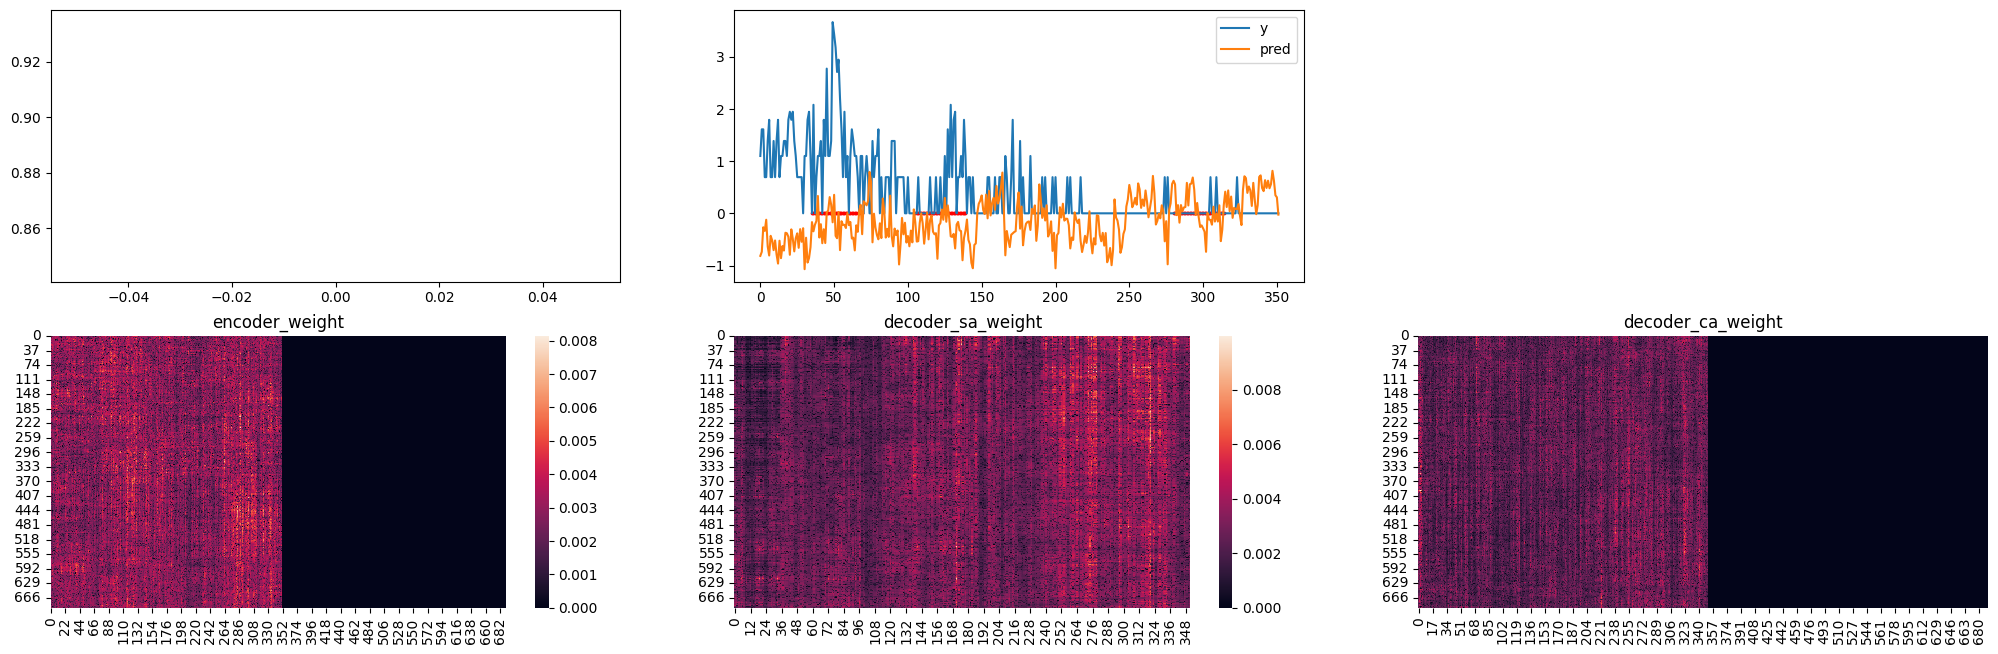

0 - loss: 0.889697790145874, lr: 0.001:   0%|          | 1/294 [00:24<2:01:53, 24.96s/it]

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
mse_loss = torch.nn.MSELoss(reduction="none")
l1_loss = torch.nn.L1Loss(reduction="none")

def loss_fn(pred, y, mask):
    mask = torch.where(mask==1, 1, 0) # Change to 0 if masked, 1 else
    loss = mse_loss(pred, y)
    # loss = l1_loss(pred, y)
    loss = mask * loss
    loss = (loss.sum()/mask.sum())
    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li = []
    window = 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        pred, encoder_weight, decoder_sa_weight, decoder_ca_weight = model(
                                                                    data["sales"].to(device), data["price"].to(device), data["dow"].to(device),
                                                                    data["mask"].to(device),
                                                                    )
        loss = loss_fn(pred, data["y"].to(device), data["mask"].to(device))
        loss.backward()
        optimizer.step()

        loss_li.append(loss.item())
        pbar.set_description(f"{e} - loss: {np.mean(loss_li[-window:])}, lr: {optimizer.param_groups[0]['lr']}")

        if n % 5 == 0:
            plt.figure(figsize=(25,12))
            nrows, ncols = 3, 3
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            # Sample
            length = data["length"][-1]
            plt.subplot(nrows, ncols, 2)
            plt.plot(data["y"][-1][:length], label="y")
            plt.plot(pred[-1][:length].detach().cpu(), label="pred")
            plt.scatter(np.arange(data["mask"][-1][:length].shape[0]), torch.where(data["mask"][-1]==0, np.nan, 0)[:length], color="red", s=3)
            plt.legend()

            # Attn
            plt.subplot(nrows, ncols, 4)
            sns.heatmap(encoder_weight[-1].mean(dim=0).detach().cpu())
            plt.title("encoder_weight")

            plt.subplot(nrows, ncols, 5)
            sns.heatmap(decoder_sa_weight[-1].mean(dim=0).detach().cpu()[:, :length])
            plt.title("decoder_sa_weight")

            plt.subplot(nrows, ncols, 6)
            sns.heatmap(decoder_ca_weight[-1].mean(dim=0).detach().cpu(), cbar=False)
            plt.title("decoder_ca_weight")

            plt.show()
            # print(encoder_weight[-1].mean(dim=0))
            # # print(encoder_weight[-1].mean(dim=0).sum(-1))

            # print(decoder_sa_weight[-1].mean(dim=0))
            # # print(decoder_sa_weight[-1].mean(dim=0).sum(-1))
            # raise

            # input()
epoch = 5
for e in range(epoch):
    train(e)
    scheduler.step()

# Eval

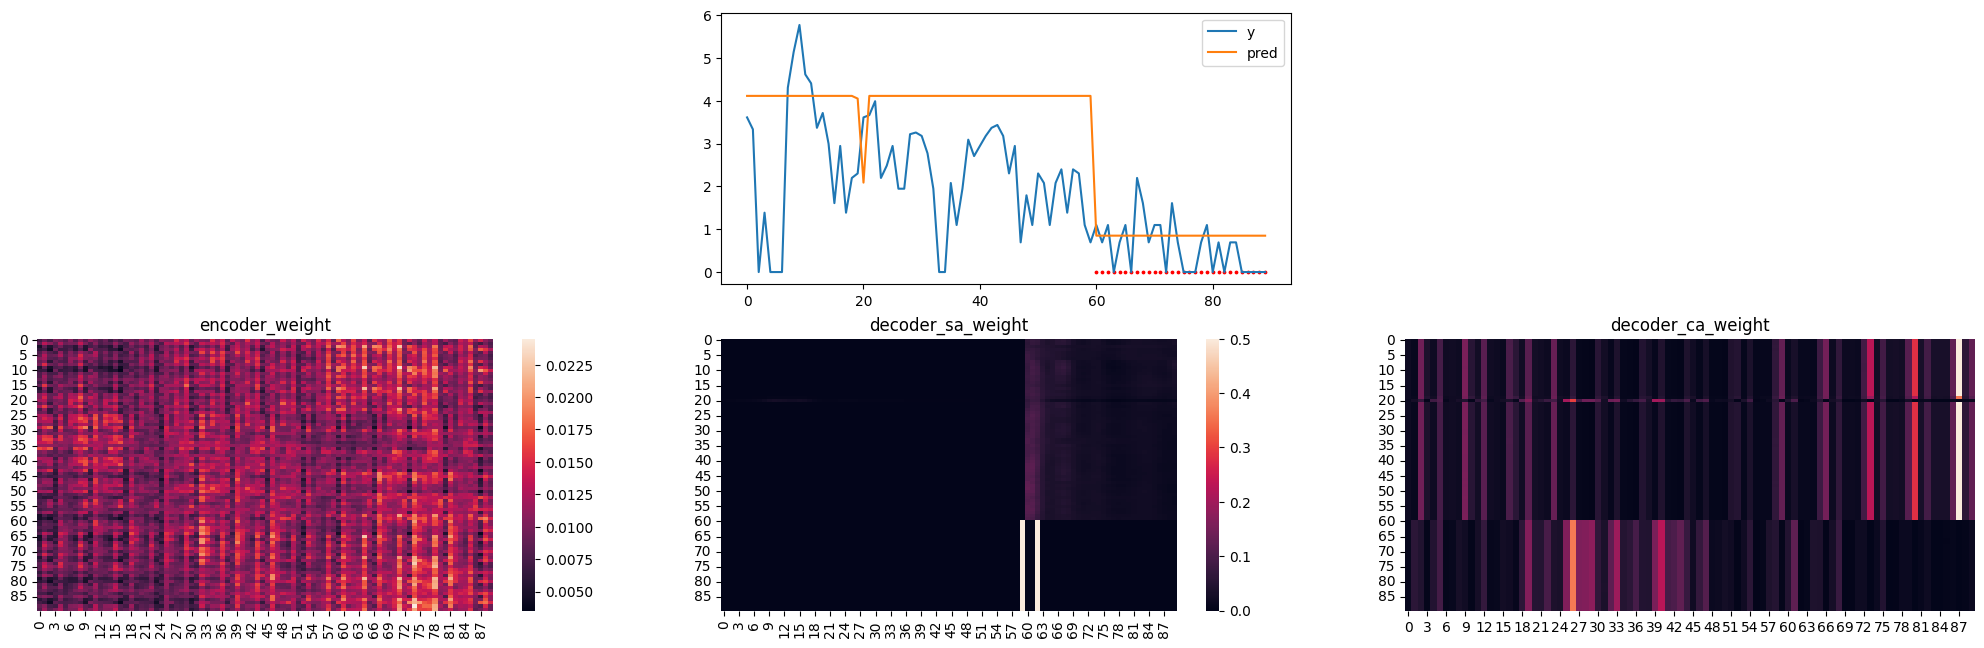

4 - loss: 0.7666091918945312, lr: 0.0009039207967999998:   0%|          | 0/294 [00:01<?, ?it/s]

In [ ]:
model.eval()
pbar = tqdm(valid_dataloader)

for n, data in enumerate(pbar):
    with torch.no_grad():
        sales = data["sales"].to(device)
        mask = data["mask"].to(device)
        # for i in range(30):
        #     pred, encoder_weight, decoder_sa_weight, decoder_ca_weight = model(
        #                                                                 sales, data["price"].to(device), data["dow"].to(device),
        #                                                                 mask
        #                                                                 )
        #     idx = torch.argmax(mask, -1)
        #     for n, i in enumerate(idx):
        #         sales[n, i] = pred[n, i]
        #         mask[n, i] = 0

        pred, encoder_weight, decoder_sa_weight, decoder_ca_weight = model(
                                                                        sales, data["price"].to(device), data["dow"].to(device),
                                                                        mask
                                                                        )

        loss = loss_fn(pred, data["y"].to(device), data["mask"].to(device))
        plt.figure(figsize=(25,12))
        nrows, ncols = 3, 3
        clear_output(wait=True)

        # Sample
        idx = torch.argmax(data["y"].max(-1).values)
        length = data["length"][idx]
        plt.subplot(nrows, ncols, 2)
        plt.plot(data["y"][idx][:length], label="y")
        plt.plot(pred[idx][:length].detach().cpu(), label="pred")
        plt.scatter(np.arange(data["mask"][idx][:length].shape[0]), torch.where(data["mask"][idx]==0, np.nan, 0)[:length], color="red", s=3)
        plt.legend()

        # Attn
        plt.subplot(nrows, ncols, 4)
        sns.heatmap(encoder_weight[idx].mean(dim=0).detach().cpu())
        plt.title("encoder_weight")

        plt.subplot(nrows, ncols, 5)
        sns.heatmap(decoder_sa_weight[idx].mean(dim=0).detach().cpu()[:, :length])
        plt.title("decoder_sa_weight")

        plt.subplot(nrows, ncols, 6)
        sns.heatmap(decoder_ca_weight[idx].mean(dim=0).detach().cpu(), cbar=False)
        plt.title("decoder_ca_weight")

        plt.show()
        pbar.set_description(f"{e} - loss: {loss.item()}, lr: {optimizer.param_groups[0]['lr']}")
        input()